In [1]:
# Import necessary libraries
# git link: https://github.com/saketd403/Visualizing-and-Understanding-Convolutional-neural-networks
# additional great link: https://github.com/sar-gupta/convisualize_nb (this link also has artickles with good visualization)
import numpy as np
import sys
import time
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, InputLayer, Flatten, Activation, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.activations import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import vgg16, imagenet_utils
import tensorflow.keras.backend as K
import numpy
import math
import matplotlib.pyplot as plt
import PIL

In [ ]:
class DConvolution2D(object):
    
    def __init__(self, layer):

        self.layer = layer

        weights = layer.get_weights()
        W = weights[0]
        b = weights[1]

        
        filters = W.shape[3]
        up_row = W.shape[0]
        up_col = W.shape[1]
        input_img = keras.layers.Input(shape = layer.input_shape[1:])

        output=keras.layers.Conv2D(filters,(up_row,up_col),kernel_initializer=tf.constant_initializer(W),
                                   bias_initializer=tf.constant_initializer(b),padding='same')(input_img)
        self.up_func = K.function([input_img], [output])
        # Deconv filter (exchange no of filters and depth of each filter)
        W = np.transpose(W, (0,1,3,2))
        # Reverse columns and rows
        W = W[::-1, ::-1,:,:]
        down_filters = W.shape[3]
        down_row = W.shape[0]
        down_col = W.shape[1]
        b = np.zeros(down_filters)
        input_d = keras.layers.Input(shape = layer.output_shape[1:])

        output=keras.layers.Conv2D(down_filters,(down_row,down_col),kernel_initializer=tf.constant_initializer(W),
                                   bias_initializer=tf.constant_initializer(b),padding='same')(input_d)
        self.down_func = K.function([input_d], [output])

    def up(self, data, learning_phase = 0):
        #Forward pass
        # print('here are deconv 2d before', data.shape)
        self.up_data = self.up_func(data)
        self.up_data=np.squeeze(self.up_data,axis=0)
        # print('after up func', self.up_data.shape)
        # self.up_data=numpy.expand_dims(self.up_data,axis=0)
        print('in deconv up function',self.up_data.shape)
        return self.up_data

    def down(self, data, learning_phase = 0):
        # Backward pass
        print('in down of deconv')
        self.down_data= self.down_func(data)
        self.down_data=np.squeeze(self.down_data,axis=0)
        # self.down_data=numpy.expand_dims(self.down_data,axis=0)
        #print(self.down_data.shape)
        return self.down_data

In [ ]:
class DActivation(object):
    def __init__(self, layer, linear = False):
        
        self.layer = layer
        self.linear = linear
        self.activation = layer.activation
        input = K.placeholder(shape = layer.output_shape)

        output = self.activation(input)
        # According to the original paper, 
        # In forward pass and backward pass, do the same activation(relu)
        # Up method
        self.up_func = K.function(
                [input], [output])
        # Down method
        self.down_func = K.function(
                [input], [output])

   
    def up(self, data, learning_phase = 0):
        print('here are we dactivation')
        self.up_data = self.up_func(data)
        self.up_data=np.squeeze(self.up_data,axis=0)
        # self.up_data=numpy.expand_dims(self.up_data,axis=0)
        print('in deactivation final shape',self.up_data.shape)
        return self.up_data

   
    def down(self, data, learning_phase = 0):
        print('in down of activation', data.shape)
        self.down_data = self.down_func(data)
        self.down_data=np.squeeze(self.down_data,axis=0)
        # self.down_data=numpy.expand_dims(self.down_data,axis=0)
        print(self.down_data.shape)
        return self.down_data

In [ ]:
class DInput(object):

    def __init__(self, layer):
        self.layer = layer
    
    # input and output of Inputl layer are the same
    def up(self, data, learning_phase = 0):
        print('input data',data.shape)
        self.up_data = data
        return self.up_data
    
    def down(self, data, learning_phase = 0):
        print('in down of input')
        #data=np.squeeze(data,axis=0)
        data=numpy.expand_dims(data,axis=0)
        self.down_data = data
        return self.down_data

In [ ]:
class DDense(object):
  
    def __init__(self, layer):

        self.layer = layer
        weights = layer.get_weights()
        W = weights[0]
        b = weights[1]
        
        # Up method
        input = Input(shape = layer.input_shape[1:])
        output = keras.layers.Dense(layer.output_shape[1],
                 kernel_initializer=tf.constant_initializer(W), bias_initializer=tf.constant_initializer(b))(input)
        self.up_func = K.function([input], [output])
        
        #Transpose W  for down method
        W = W.transpose()
        self.input_shape = layer.input_shape
        self.output_shape = layer.output_shape
        b = np.zeros(self.input_shape[1])
        flipped_weights = [W, b]
        input = Input(shape = self.output_shape[1:])
        output = keras.layers.Dense(self.input_shape[1:],
                 kernel_initializer=tf.constant_initializer(W), bias_initializer=tf.constant_initializer(b))(input)
        self.down_func = K.function([input], [output])
    

    def up(self, data, learning_phase = 0):
      
        print('in d dense')
        self.up_data = self.up_func([data])
        self.up_data=np.squeeze(self.up_data,axis=0)
        self.up_data=numpy.expand_dims(self.up_data,axis=0)
        print(self.up_data.shape)
        return self.up_data
        
    def down(self, data, learning_phase = 0):
        print('in down of dense')
        self.down_data = self.down_func([data])
        self.down_data=np.squeeze(self.down_data,axis=0)
        self.down_data=numpy.expand_dims(self.down_data,axis=0)
        print(self.down_data.shape)
        return self.down_data

In [ ]:
class DFlatten(object):

    def __init__(self, layer):
   
        self.layer = layer
        self.shape = layer.input_shape[1:]
        self.up_func = K.function(
                [layer.input], [layer.output])

    # Flatten 2D input into 1D output
    def up(self, data, learning_phase = 0):

        print('in d flatten')
        self.up_data = self.up_func([data])
        self.up_data=np.squeeze(self.up_data,axis=0)
        self.up_data=numpy.expand_dims(self.up_data,axis=0)
        print(self.up_data.shape)
        return self.up_data

    # Reshape 1D input into 2D output
    def down(self, data, learning_phase = 0):
        print('in down of flatten')
        new_shape = [data.shape[0]] + list(self.shape)
        assert np.prod(self.shape) == np.prod(data.shape[1:])
        self.down_data = np.reshape(data, new_shape)
        return self.down_data

In [ ]:
class DPooling(object):

    def __init__(self, layer):

        self.layer = layer
        self.poolsize = layer.pool_size
       
    
    def up(self, data, learning_phase = 0):
        print('in d pooling')
        [self.up_data, self.switch] = \
                self.__max_pooling_with_switch(data, self.poolsize)
        return self.up_data

    def down(self, data, learning_phase = 0):
        print('in down of pooling')
        self.down_data = self.__max_unpooling_with_switch(data, self.switch)
        return self.down_data
    
    def __max_pooling_with_switch(self, input, poolsize):

        switch = np.zeros(input.shape)
        out_shape = list(input.shape)
        row_poolsize = int(poolsize[0])
        col_poolsize = int(poolsize[1])
        print(row_poolsize)
        print(col_poolsize)
        out_shape[1] = math.floor(out_shape[1] / poolsize[0])
        out_shape[2] = math.floor(out_shape[2] / poolsize[1])
        print(out_shape)
        pooled = np.zeros(out_shape)
        
        for sample in range(input.shape[0]):
            for dim in range(input.shape[3]):
                for row in range(out_shape[1]):
                    for col in range(out_shape[2]):
                        patch = input[sample, 
                                row * row_poolsize : (row + 1) * row_poolsize,
                                col * col_poolsize : (col + 1) * col_poolsize,dim]
                        max_value = patch.max()
                        pooled[sample, row, col,dim] = max_value
                        max_col_index = patch.argmax(axis = 1)
                        max_cols = patch.max(axis = 1)
                        max_row = max_cols.argmax()
                        max_col = max_col_index[max_row]
                        switch[sample, 
                                row * row_poolsize + max_row, 
                                col * col_poolsize + max_col,
                              dim]  = 1
        return [pooled, switch]
    
    # Compute unpooled output using pooled data and switch
    def __max_unpooling_with_switch(self, input, switch):

        print('switch '+str(switch.shape))
        print('input  '+str(input.shape))
        tile = np.ones((math.floor(switch.shape[1] / input.shape[1]), 
            math.floor( switch.shape[2] / input.shape[2])))
        print('tile '+str(tile.shape))
        tile=numpy.expand_dims(tile,axis=2)
        input=numpy.squeeze(input,axis=0)
        out = np.kron(input, tile)
        print('out '+str(out.shape))
        unpooled = out * switch
        # unpooled=numpy.expand_dims(unpooled,axis=0)
        return unpooled

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


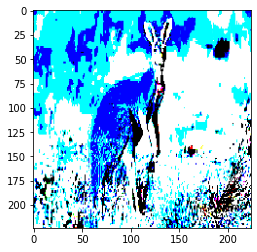

In [ ]:
image_path = "/content/kangaroo.jpg"
layer_name = 'block3_conv3'
feature_to_visualize = 127
visualize_mode = 'all'

model = vgg16.VGG16(weights = 'imagenet', include_top = True)
layer_dict = dict([(layer.name, layer) for layer in model.layers])
model.summary()

# Load data and preprocess
img = Image.open(image_path)
img = img.resize((224, 224),resample=PIL.Image.NEAREST)

img_array = np.array(img)
img_array = img_array[np.newaxis, :]
img_array = img_array.astype(np.float)
img_array = imagenet_utils.preprocess_input(img_array)

#Original image
plt.imshow(img_array[0])
plt.show()

In [ ]:
# deconv = visualize(model, [img_array], layer_name, feature_to_visualize)
# def visualize(model, data, layer_name, feature_to_visualize, visualize_mode='all'):
data = img_array
layer_name = 'block3_conv2'
feature_to_visualize = 63
deconv_layers = []
# Stack layers
for i in range(len(model.layers)):
    if isinstance(model.layers[i], Convolution2D):
        deconv_layers.append(DConvolution2D(model.layers[i]))
        deconv_layers.append(
                DActivation(model.layers[i]))
    elif isinstance(model.layers[i], MaxPooling2D):
        deconv_layers.append(DPooling(model.layers[i]))
    elif isinstance(model.layers[i], Dense):
        deconv_layers.append(DDense(model.layers[i]))
        deconv_layers.append(
                DActivation(model.layers[i]))
    elif isinstance(model.layers[i], Activation):
        deconv_layers.append(DActivation(model.alyers[i]))
    elif isinstance(model.layers[i], Flatten):
        deconv_layers.append(DFlatten(model.layers[i]))
    elif isinstance(model.layers[i], InputLayer):
        deconv_layers.append(DInput(model.layers[i]))
    else:
        print('Cannot handle this type of layer')
        print(model.layers[i].get_config())
        sys.exit()
    if layer_name == model.layers[i].name:
        break

# Forward pass
# print(deconv_layers[0])
deconv_layers[0].up(data)
for i in range(1, len(deconv_layers)):
    print('i is', i)
    deconv_layers[i].up(deconv_layers[i - 1].up_data)

output = deconv_layers[-1].up_data
print(output.shape)

assert output.ndim == 2 or output.ndim == 4
if output.ndim == 2:
    feature_map = output[:, feature_to_visualize]
else:
    feature_map = output[:,:, :, feature_to_visualize]
if 'max' == visualize_mode:
    max_activation = feature_map.max()
    temp = feature_map == max_activation
    feature_map = feature_map * temp
elif 'all' != visualize_mode:
    print('Illegal visualize mode')
    sys.exit()
output = np.zeros_like(output)

if 2 == output.ndim:
    output[:, feature_to_visualize] = feature_map
else:
    output[:,: , :, feature_to_visualize] = feature_map


# Backward pass
deconv_layers[-1].down(output)
for i in range(len(deconv_layers) - 2, -1, -1):
    print('i is', i)
    deconv_layers[i].down(deconv_layers[i + 1].down_data)
deconv = deconv_layers[0].down_data
deconv = deconv.squeeze()

# return deconv

input data (1, 224, 224, 3)
i is 1
in deconv up function (1, 224, 224, 64)
i is 2
here are we dactivation
in deactivation final shape (1, 224, 224, 64)
i is 3
in deconv up function (1, 224, 224, 64)
i is 4
here are we dactivation
in deactivation final shape (1, 224, 224, 64)
i is 5
in d pooling
2
2
[1, 112, 112, 64]
i is 6
in deconv up function (1, 112, 112, 128)
i is 7
here are we dactivation
in deactivation final shape (1, 112, 112, 128)
i is 8
in deconv up function (1, 112, 112, 128)
i is 9
here are we dactivation
in deactivation final shape (1, 112, 112, 128)
i is 10
in d pooling
2
2
[1, 56, 56, 128]
i is 11
in deconv up function (1, 56, 56, 256)
i is 12
here are we dactivation
in deactivation final shape (1, 56, 56, 256)
i is 13
in deconv up function (1, 56, 56, 256)
i is 14
here are we dactivation
in deactivation final shape (1, 56, 56, 256)
(1, 56, 56, 256)
in down of activation (1, 56, 56, 256)
(1, 56, 56, 256)
i is 13
in down of deconv
i is 12
in down of activation (1, 56, 56,

In [ ]:
deconv.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


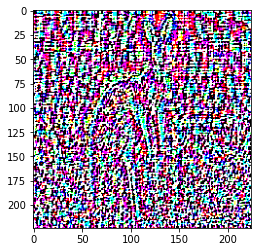

In [ ]:
plt.imshow(deconv)
plt.show()

(224, 224, 3)


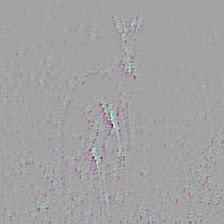

In [ ]:
print(deconv.shape)
# postprocess and save image
#deconv = np.transpose(deconv, ())
deconv = deconv - deconv.min()
deconv *= 1.0 / (deconv.max() + 1e-8)
#deconv = deconv[:, :, ::-1]
uint8_deconv = (deconv * 255).astype(np.uint8)
img = Image.fromarray(uint8_deconv, 'RGB')
img.save('...\kangaroo{}_{}_{}.png'.format(layer_name, feature_to_visualize, visualize_mode))
img